# package & data loading

In [4]:
import os

import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import dtreeviz
import graphviz

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder

In [5]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

path_data = "data"
path_res_all = "res/worksession20230825/res_all"
path_res_by_cluster = "res/worksession20230825/by_cluster"

In [6]:
df = pd.read_csv(os.path.join(path_data, "df_final_analysis.txt"), sep="\t", header=0)
pd.set_option('display.max_columns', None)
df

,pds_code,General|Category no empty cell/not merged,General|Product type no empty cell/not merged,General|Subcategory no empty cell/not merged,Emulsifier and oil|Ratio total oil/emulsifier,Emulsifier and oil|Phospholipids g/100mL,Total Lipids g/100g product,FA_Sat g/100gFA,FA_Mono unsat g/100gFA,FA_Poly unsatg/100gFA,Pasteurization homo|P Pasto/homo bar,Pasteurization homo|T°C Pasto/Homo,Pasteurization|T°C Pasto,Pasteurization|Time Pasto sec,Sterilization US homo|P Sterilization US bar,Sterilization US homo|T°C Steril US,SterilizationDS homo|P Steril DS,SterilizationDS homo|T°C Steril DS,Sterilization|Direct/indirect Ste,Sterilization|F0,Sterilization|T°C Steril,Sterilization|Time Ste sec,Protein|Type of protein,Protein|intact / hydrolysate/am acids,"Protein|Prot level Nx6,25 g/100g product","Protein|casein Nx6,25g/100g product","Protein|whey protNx6,25g/100g product","Protein|SOY prot g/100g productNx6,25","Protein|PEA prot g/100g productNx6,25",Protein|Content kg/L,Stabilizers thickners|Type,Stabilizers thickners|Amount kg/1000L,Calcium minerals|Ca levelg/100g,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas,target,Emulsifier and oil|Emulsifier_Citrem LIQUID E472c,Emulsifier and oil|Emulsifier_Citrem POWDER E472c,Emulsifier and oil|Emulsifier_DIMODAN E471,Emulsifier and oil|Emulsifier_KIRNOL E471,Emulsifier and oil|Emulsifier_LAMEMUL E471,Emulsifier and oil|Emulsifier_Soy lecithin LIQUID E322,Emulsifier and oil|Emulsifier_Soy lecithin POWDER E322,Emulsifier and oil|Emulsifier_Sunflower lecithin E322,Emulsifier_total_amount,Emulsifier and oil|Oil_Algae oil DHA+EPA,Emulsifier and oil|Oil_Anhydrous milk fat,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Coconut oil,Emulsifier and oil|Oil_Corn oil,Emulsifier and oil|Oil_EPA,Emulsifier and oil|Oil_Egg lipids,Emulsifier and oil|Oil_MCT oil,Emulsifier and oil|Oil_OB 5,Emulsifier and oil|Oil_OB Canola/HO,Emulsifier and oil|Oil_Oil Blend Preterm 3,Emulsifier and oil|Oil_Oil Tuna Fish /DHA,Emulsifier and oil|Oil_Oil arachidonic acid / ARA,Emulsifier and oil|Oil_Oil blend Acropolis & Algae oil DHA+EPA,Emulsifier and oil|Oil_Oil blend Fish DHA EPA,Emulsifier and oil|Oil_Oil evening primrose,Emulsifier and oil|Oil_Oil fish EPA:18 DHA:12,Emulsifier and oil|Oil_Organic OB POF,Emulsifier and oil|Oil_Palm oil,Emulsifier and oil|Oil_Rapeseed oil,Emulsifier and oil|Oil_Soy oil,Emulsifier and oil|Oil_Sunflower oil,Emulsifier and oil|Oil_corn oil,Oil_total_amount,Polysaccharides_Fructose,Polysaccharides_Glucose,Polysaccharides_Glucose syrup,Polysaccharides_Isomaltulose,Polysaccharides_Lactose,Polysaccharides_Liquid maltodextrin,Polysaccharides_Maltodextrin,Polysaccharides_Starch,Polysaccharides_Sucrose,Polysaccharides_Sugar,Polysaccharides_total_amount,Protein_Calcium caseinates,Protein_Casein hydrolysate,Protein_Concentrated skimmed milk,Protein_Demineralized whey permeate 125% protein ORGANIC,Protein_Demineralized whey permeate 90,Protein_IP LQD DCI 12% No premix UF,Protein_IP PWD HYDR ACID WHEY,Protein_LIsoleucine,Protein_LLeucine,Protein_LValine,Protein_Lactofidus BP POF P1,Protein_Milk Casein Isolate,Protein_Milk Protein Concentrate,Protein_Milk Protein Isolate,Protein_Milk minerals concentrates,Protein_Pea protein,Protein_Pea protein isolate,Protein_Pepti permeate,Protein_Potassium caseinate,Protein_Skimmed milk Liquid,Protein_Skimmed milk Powder ORGANIC,Protein_Sodium caseinate,Protein_Soy protein isolate,Protein_WPC,Protein_WPC80 Native,Protein_WPC80 Native low Lactose,Protein_WPC83 Native,Protein_WPI Acid,Protein_WPI Native,Protein_WPI neutralized,Protein_WPI sweet,Protein_Whey protein hydrolysate,Protein_Whey rich in milk calcium,Protein_Yoghurt powder,Protein_whey protein hydrolysate,Protein_total_amount
0,10103262,Adult ONS,CUBITAN,NaN,30.882353,NaN,3.225499,14.388776,57.052004,28.559220,550+50,60,95.0,30.0,NaN,NaN,100+0,60.0,Indirect,15.561806,127.0,240.0,Dairy,Intact,9.634344,NaN,Na

# data preparation

### outlier and non-standard entries

In [7]:
df = df[df["Total Lipids g/100g product"] != 50]  # remove outlier product: very high total lipid, no protein

df.loc[:, "Pasteurization  homo|T°C Pasto/Homo"] = pd.to_numeric(
    df["Pasteurization  homo|T°C Pasto/Homo"].replace("72-75", '73'))
df.loc[:, "SterilizationDS homo|P Steril DS"] = df["SterilizationDS homo|P Steril DS"].replace(">180", '181')

In [8]:
def split_plus_to_numeric(df, column_to_split, remove_origin=True):
    df[[column_to_split + ' first', column_to_split + ' second']] = df[column_to_split].str.split('+',
                                                                                                  expand=True).apply(
        pd.to_numeric).fillna(0, inplace=False)
    df.drop(column_to_split, axis=1, inplace=True)
    return df


col_to_split = ["Pasteurization  homo|P Pasto/homo bar", "Sterilization US homo|P Sterilization US bar",
                "SterilizationDS homo|P Steril DS"]

for col in col_to_split:
    print(f"\t----- {col} -----")
    print("\nbefore split:\n", df[col].value_counts(), "\n\n")
    df = split_plus_to_numeric(df, col)
    print("after split:\n", df[col + ' first'].value_counts(), "\n", df[col + ' second'].value_counts(), "\n\n")


	----- Pasteurization  homo|P Pasto/homo bar -----

before split:
 Pasteurization  homo|P Pasto/homo bar
550+50      29
400+50      20
250+50      15
200+50       7
50+100       5
450+50       4
220+30       3
150+50       2
260+30       2
250 + 50     2
180+50       2
250+30       1
230+40       1
300+50       1
325+50       1
350+50       1
Name: count, dtype: int64 


after split:
 Pasteurization  homo|P Pasto/homo bar first
0.0      33
550.0    29
400.0    20
250.0    18
200.0     7
50.0      5
450.0     4
220.0     3
150.0     2
260.0     2
180.0     2
230.0     1
300.0     1
325.0     1
350.0     1
Name: count, dtype: int64 
 Pasteurization  homo|P Pasto/homo bar second
50.0     84
0.0      33
30.0      6
100.0     5
40.0      1
Name: count, dtype: int64 


	----- Sterilization US homo|P Sterilization US bar -----

before split:
 Sterilization US homo|P Sterilization US bar
250+50      5
250 + 50    4
Name: count, dtype: int64 


after split:
 Sterilization US homo|P Sterilizatio

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1167835907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [9]:
df["Pasteurization  homo|T°C Pasto/Homo"] = pd.to_numeric(df["Pasteurization  homo|T°C Pasto/Homo"])

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\343474571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### ratio of oil and emulsifier

In [10]:
df["ratio_total_oil_emulsifier"] = df["Oil_total_amount"] / df["Emulsifier_total_amount"]
df.drop('Emulsifier and oil|Ratio total oil/emulsifier', axis=1, inplace=True)
df[["Oil_total_amount", "Emulsifier_total_amount", "ratio_total_oil_emulsifier"]].describe()


C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1965026945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1965026945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Oil_total_amount,Emulsifier_total_amount,ratio_total_oil_emulsifier
count,120.000000,103.000000,103.000000
mean,53.906487,2.889209,24.035595
std,50.674022,2.259902,16.283826
min,0.968000,0.450000,2.565554
25%,32.640000,1.658000,17.944957
50%,44.000000,2.050000,20.165692
75%,61.272500,3.080000,28.871495
max,403.000000,11.106000,115.868889


There are missing values in new created ratio_total_oil_emulsifier column

In [11]:
# plt.plot(df['ratio_total_oil_emulsifier'], df['target'], 'o')

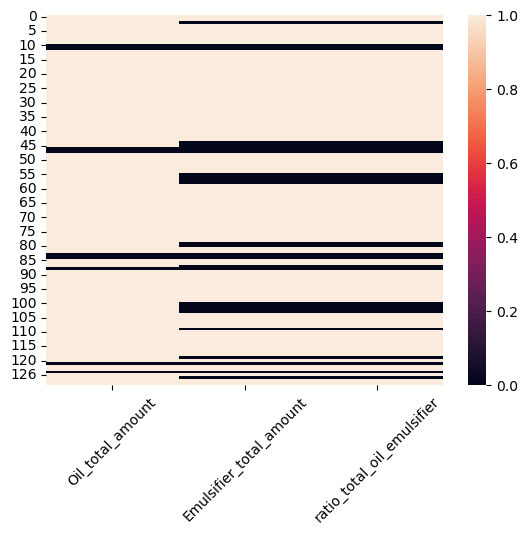

In [12]:
sns.heatmap(~df[["Oil_total_amount", "Emulsifier_total_amount", "ratio_total_oil_emulsifier"]].isna())
plt.xticks(rotation=45);

In [13]:
df[["Oil_total_amount", "target"]][df["Emulsifier_total_amount"].isna()]

,Oil_total_amount,target
2,17.620000,3.0
10,NaN,1.0
11,NaN,1.0
44,38.860000,2.0
45,67.772000,3.0
46,NaN,1.0
47,NaN,1.0
55,48.194000,3.0
56,34.950000,1.0
57,403.000000,3.0


In [14]:
df.loc[df["Oil_total_amount"].isna(), 'ratio_total_oil_emulsifier'] = 0
df["ratio_total_oil_emulsifier"].fillna(df['ratio_total_oil_emulsifier'].max() + 1, inplace=True)

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\4145699645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Missing values

Text(0.5, 1.0, 'missing values')

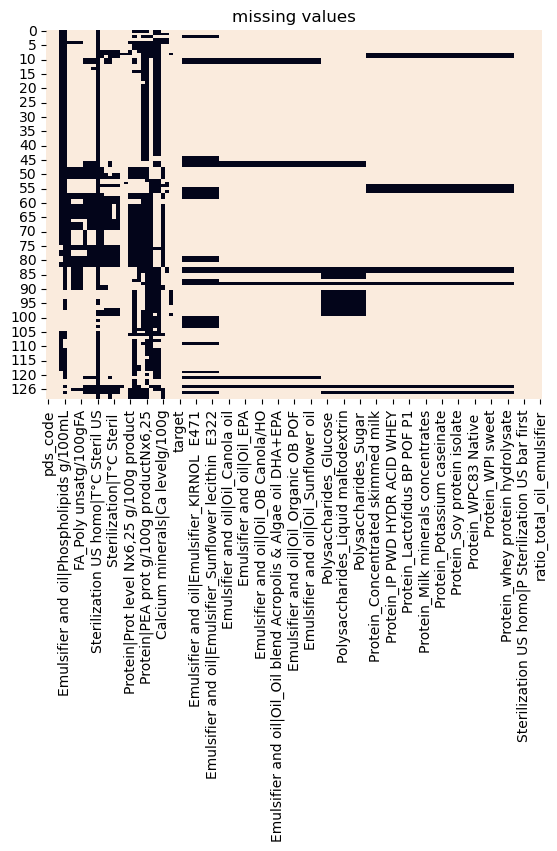

In [15]:
sns.heatmap(~df.isnull(), cbar=False)
plt.title('missing values')

### physical measures 

Text(0.5, 1.0, 'missing values of physical measurements')

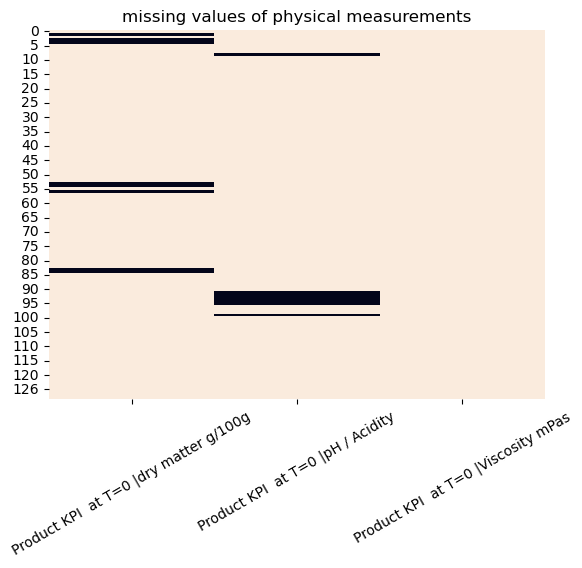

In [16]:
sns.heatmap(~df.loc[:, df.columns.str.startswith("Product KPI")].isnull(), cbar=False)
plt.xticks(rotation=30)
plt.title("missing values of physical measurements")

In [17]:
df.loc[:, df.columns.str.startswith("Product KPI")].describe()

,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas
count,121.000000,122.000000,129.000000
mean,25.809786,6.525738,4776.168992
std,11.269757,1.189250,19441.689473
min,0.185600,2.900000,2.000000
25%,18.370000,6.700000,7.000000
50%,28.310000,6.800000,20.000000
75%,33.437424,7.000000,100.000000
max,52.100000,8.000000,100000.000000


In [18]:
# fill the missing values of physical measurements with mean values
for col in df.columns[df.columns.str.startswith("Product KPI")]:
    df[col] = df[col].fillna(df[col].median())
    

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\576187657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### others: numerical values

In [19]:
col_num = df.columns[df.dtypes == 'float64']
for col in col_num[df[col_num].isnull().any()]:
    print(col)

Emulsifier and oil|Phospholipids g/100mL
Total Lipids g/100g product
FA_Sat g/100gFA
FA_Mono unsat g/100gFA
FA_Poly unsatg/100gFA
Pasteurization  homo|T°C Pasto/Homo
Pasteurization|T°C Pasto
Pasteurization|Time Pasto sec
Sterilization US homo|T°C Steril US
SterilizationDS homo|T°C Steril DS
Sterilization|F0
Sterilization|T°C Steril 
Sterilization|Time Ste sec
Protein|Prot level Nx6,25 g/100g product
Protein|casein Nx6,25g/100g product
Protein|whey protNx6,25g/100g product
Protein|SOY prot g/100g productNx6,25
Protein|PEA prot g/100g productNx6,25
Protein|Content kg/L
Stabilizers  thickners|Amount kg/1000L
Calcium minerals|Ca levelg/100g
Emulsifier and oil|Emulsifier_Citrem LIQUID  E472c
Emulsifier and oil|Emulsifier_Citrem POWDER  E472c
Emulsifier and oil|Emulsifier_DIMODAN  E471
Emulsifier and oil|Emulsifier_KIRNOL  E471
Emulsifier and oil|Emulsifier_LAMEMUL  E471 
Emulsifier and oil|Emulsifier_Soy lecithin LIQUID  E322
Emulsifier and oil|Emulsifier_Soy lecithin POWDER  E322
Emulsifie

In [20]:
col_obj = df.columns[df.dtypes == 'object']
df[col_obj[df[col_obj].isnull().any()]]

,General|Subcategory no empty cell/not merged,Sterilization|Direct/indirect Ste,Protein|Type of protein,Protein|intact / hydrolysate/am acids,Stabilizers thickners|Type
0,NaN,Indirect,Dairy,Intact,NaN
1,NaN,Indirect,Dairy,Intact,NaN
2,NaN,Indirect,Dairy,Hydrolyzed,Modified starch
3,NaN,Indirect,Dairy,Intact,NaN
4,NaN,Indirect,Dairy,Intact,NaN
...,...,...,...,...,...
125,plant proteins,NaN,NaN,Intact,NaN
126,HEHP. plant proteins,NaN,Plant based,Intact,NaN
127,PKU,NaN,Dairy,Intact,Cellulose gum
128,HEHP. plant proteins,Direct,Plant based,Intact,Cellulose gum


In [21]:
# fill the missing values
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].fillna(0)
    elif df[column].dtype == 'object':
        df[column] = df[column].fillna('NA')

C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1589845567.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\1589845567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_processed = df.copy()

# cluster filtering

In [23]:
# use all the products: 
cluster_name = 'all'
df_cluster = df_processed.copy()
path_res = path_res_all

In [24]:
# table of filters for clusters
df_filters = pd.DataFrame(columns=["name", "criteria_col", "col_value"])
df_filters.loc[len(df_filters.index)] = ["category_imf", "General|Category no empty cell/not merged", "Core Milks"]
df_filters.loc[len(df_filters.index)] = ["protein_type_intact", "Protein|intact / hydrolysate/am acids", "Intact"]
df_filters.loc[len(df_filters.index)] = ["protein_type_hydrolyzed", "Protein|intact / hydrolysate/am acids", "Hydrolyzed"]
df_filters.set_index('name', inplace=True)
df_filters


,criteria_col,col_value
name,,
category_imf,General|Category no empty cell/not merged,Core Milks
protein_type_intact,Protein|intact / hydrolysate/am acids,Intact
protein_type_hydrolyzed,Protein|intact / hydrolysate/am acids,Hydrolyzed


In [25]:
def get_cluster(df, cluster_name):
    criteria_col = df_filters.loc[cluster_name, "criteria_col"]
    col_value = df_filters.loc[cluster_name, "col_value"]
    path_res = os.path.join(path_res_by_cluster, cluster_name)
    if not os.path.exists(path_res):
        os.makedirs(path_res)

    df_cluster = df[df[criteria_col] == col_value]
    return df_cluster, path_res

In [26]:
# # or choose a cluster (optional)
# cluster_name = df_filters.index[2]
# df_cluster, path_res = get_cluster(df_processed, cluster_name)

In [27]:
# information of clusters
num_prod = len(df_cluster)
print("\nnumber of products in cluster", cluster_name, ":", num_prod)
print(df_cluster[["target"]].value_counts())


number of products in cluster all : 129
target
2.0       59
1.0       36
3.0       30
4.0        4
Name: count, dtype: int64


# dimension reduction

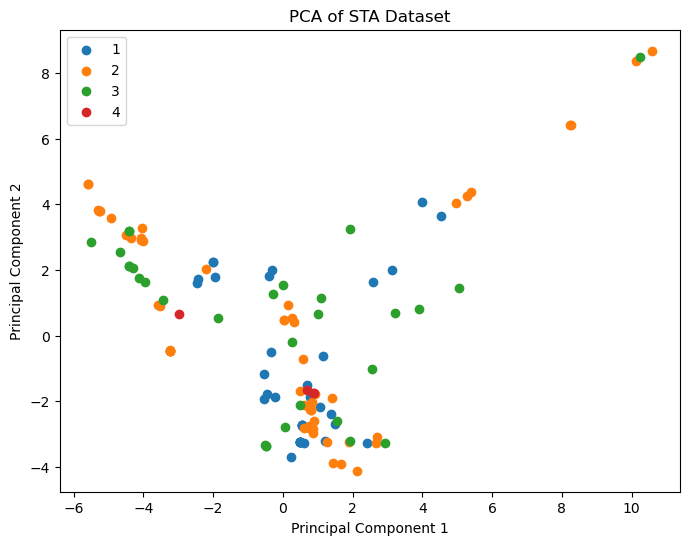

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_num = df_cluster.select_dtypes(include='number')
X_standardized = StandardScaler().fit_transform(X_num)
pca = PCA(n_components=2)

# Fit and transform the data to the first two principal components
X_pca = pca.fit_transform(X_standardized)

# Plot the results
plt.figure(figsize=(8, 6))
for i in [1, 2, 3, 4]:
    plt.scatter(X_pca[y_clf == i, 0], X_pca[y_clf == i, 1], label=i)

plt.title('PCA of STA Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [43]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.09244446, 0.07677388])

In [45]:
# Create a DataFrame to display the composition of components
component_names = [f'PC{i+1}' for i in range(pca.components_.shape[0])]
components_df = pd.DataFrame(data=pca.components_, columns=X_num.columns, index=component_names)

# Display the composition of components
print("Composition of Components:")
print(components_df)

Composition of Components:
     Emulsifier and oil|Phospholipids g/100mL  Total Lipids g/100g product   
PC1                                  0.090074                     0.155222  \
PC2                                  0.032020                    -0.190362   

     FA_Sat g/100gFA  FA_Mono unsat g/100gFA  FA_Poly unsatg/100gFA   
PC1         0.126654                0.131938               0.098593  \
PC2         0.038886               -0.192947              -0.192147   

     Pasteurization  homo|T°C Pasto/Homo  Pasteurization|T°C Pasto   
PC1                             0.219143                  0.216488  \
PC2                            -0.096386                 -0.177691   

     Pasteurization|Time Pasto sec  Sterilization US homo|T°C Steril US   
PC1                      -0.005494                             0.169669  \
PC2                      -0.080859                             0.170274   

     SterilizationDS homo|T°C Steril DS  Sterilization|F0   
PC1                       

# decision tree classification

In [28]:
def process_for_clf(df):
    y = pd.Categorical(df["target"])
    X = df.drop(["pds_code", "target"], axis=1)
    # numeric features
    X_num = X.select_dtypes(include='number')
    X_num.fillna(0, inplace=True)
    # categorical features
    X_obj = X.select_dtypes(include='object')
    enc = OneHotEncoder(handle_unknown='ignore')
    X_obj_onehot = enc.fit_transform(X_obj)
    X_obj_onehot = enc.transform(X_obj).toarray()
    X_obj_onehot_name = enc.get_feature_names_out(X_obj.columns)
    df_X_obj_onehot = pd.DataFrame(X_obj_onehot, columns=X_obj_onehot_name, index=X.index)
    X_enc = X.drop(X_obj.columns, axis=1)
    X_enc = pd.concat([X_enc, df_X_obj_onehot], axis=1)
    # feature combination
    X_final = X_enc.fillna(0)
    return X_final, y


## modeling with all variables

In [30]:
# manully delete variables
# col_to_drop = ['Pasteurization  homo|P Pasto/homo bar first', 'Product KPI  at T=0 |Viscosity mPas', 'Pasteurization|T°C Pasto']
# col_to_drop = ["Polysaccharides_Glucose"]
# for col in col_to_drop: 
#     df_cluster.drop(col, axis=1, inplace=True)
# df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 129
Columns: 120 entries, pds_code to ratio_total_oil_emulsifier
dtypes: float64(112), object(8)
memory usage: 121.9+ KB


In [48]:
from sklearn import svm
X_clf, y_clf = process_for_clf(df_cluster)
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X_clf.columns
svm = svm.SVC(kernel='linear')
svm.fit(X_clf, y_clf)
f_importances(svm.coef_, features_names)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\sunqb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\743999513.py", line 13, in <module>
    f_importances(svm.coef_, features_names)
  File "C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\743999513.py", line 5, in f_importances
    imp,names = zip(*sorted(zip(imp,names)))
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\sunqb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\sunqb\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1396, i

In [54]:
y_pred = svm.predict(X_clf)
print("accuracy_score =", accuracy_score(y_clf, y_pred))


accuracy_score = 1.0


In [31]:
X_clf, y_clf = process_for_clf(df_cluster)
print(X_clf.shape)
clf_whole = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
clf_whole.fit(X_clf, y_clf)
pred = clf_whole.predict(X_clf)
print("accuracy_score =", accuracy_score(y_clf, pred))

(129, 238)
accuracy_score = 0.8372093023255814


### decision tree visualization

C:\Users\sunqb\AppData\Local\Temp\ipykernel_20364\2871521687.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


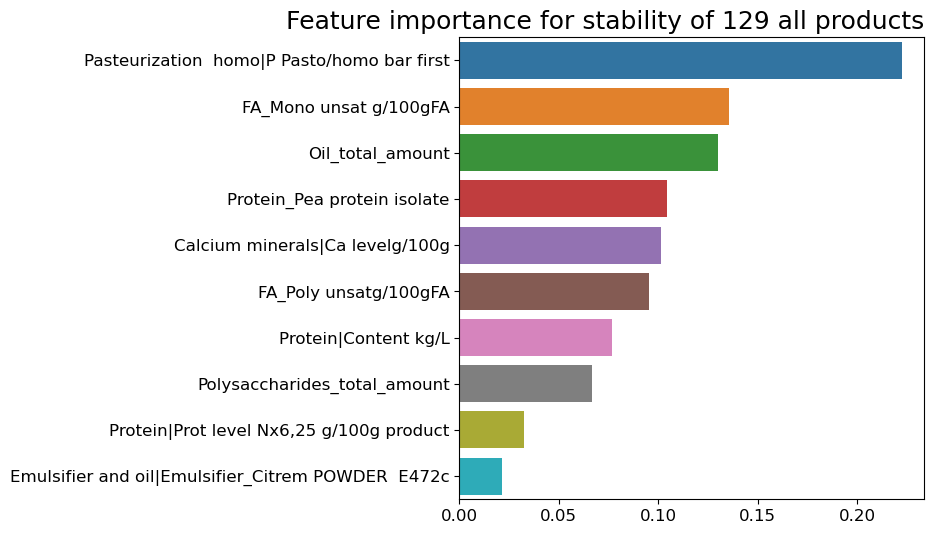

In [32]:
importance = clf_whole.feature_importances_
df_importance = pd.DataFrame(importance, index=X_clf.columns)
df_importance.sort_values(by=[0], ascending=False, inplace=True)
plt.rcParams['figure.figsize'] = (6, 6)
sns_plot = sns.barplot(data=df_importance[:10].transpose(), orient='h')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"Feature importance for stability of {len(df_cluster)} {cluster_name} products", size=18, loc='right')
fig = sns_plot.get_figure()
fig.show()


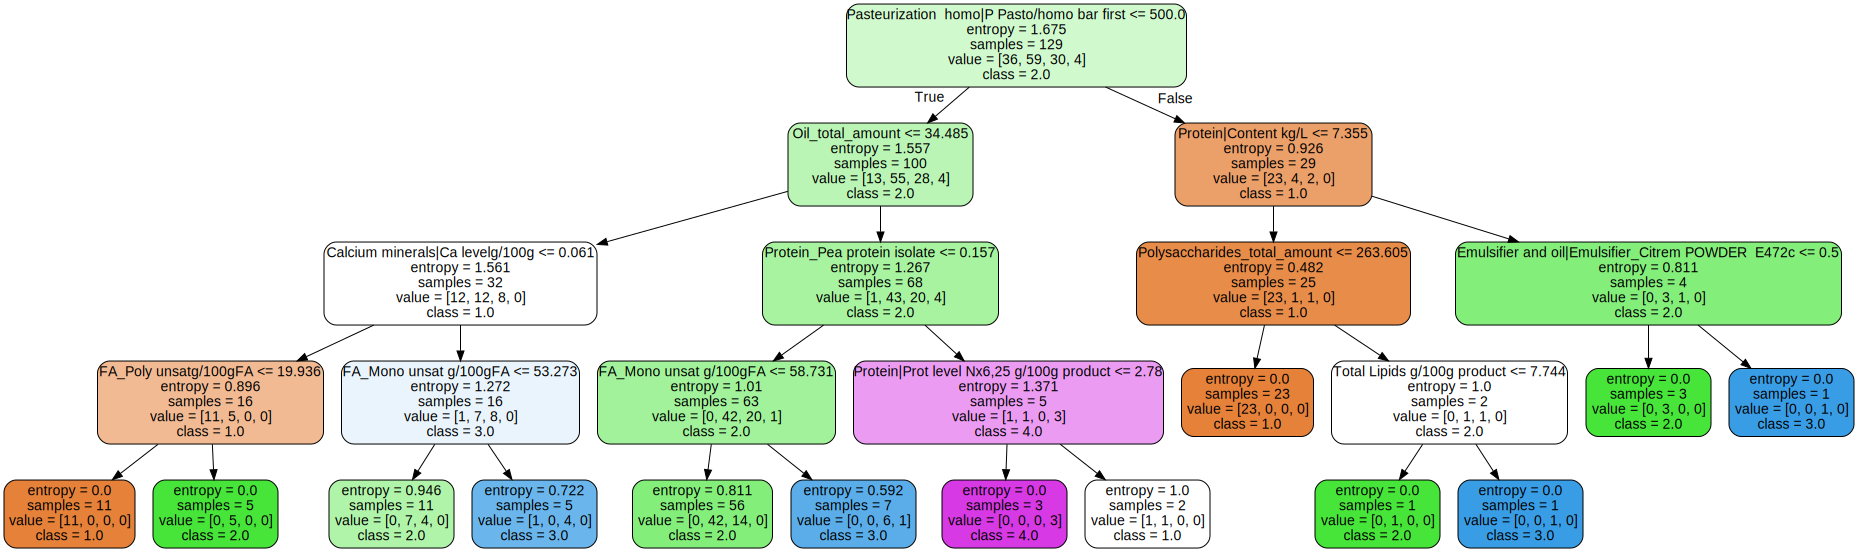

In [33]:
class_names = y_clf.unique().sort_values(ascending=True).astype(str).tolist()
dot_data = tree.export_graphviz(clf_whole, out_file=None,
                                feature_names=X_clf.columns,
                                class_names=class_names,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
graph.render(os.path.join(path_res, f"decision_tree_clf_{cluster_name}.png"))
graph

In [34]:
# # explanation by SHAP
# import shap
# shap.initjs()
# explainer = shap.TreeExplainer(clf_sel)
# shap_values = explainer.shap_values(X_clf)
# shap.summary_plot(shap_values, X_clf, feature_names=X_clf.columns, class_names=class_names)

In [27]:
# # explanation by SHAP
# import shap
# shap.initjs()
# explainer = shap.TreeExplainer(clf_sel)
# shap_values = explainer.shap_values(X_clf)
# shap.summary_plot(shap_values, X_clf, feature_names=X_clf.columns, class_names=class_names)

## modeling with selected variables

In [56]:
col_to_keep = ["pds_code", "target", "Total Lipids g/100g product", "ratio_total_oil_emulsifier", "Protein|Type of protein", "Protein|intact / hydrolysate/am acids", "Calcium minerals|Ca levelg/100g",
               "Pasteurization  homo|P Pasto/homo bar first"]
# simplified ingredient columns: keep only total amounts of each category
col_to_keep.extend(df_processed.columns[df_processed.columns.str.contains('total_amount')]) 
print(col_to_keep)
df_selected = df_processed[col_to_keep]

['pds_code', 'target', 'Total Lipids g/100g product', 'ratio_total_oil_emulsifier', 'Protein|Type of protein', 'Protein|intact / hydrolysate/am acids', 'Calcium minerals|Ca levelg/100g', 'Pasteurization  homo|P Pasto/homo bar first', 'Emulsifier_total_amount', 'Oil_total_amount', 'Polysaccharides_total_amount', 'Protein_total_amount']


In [57]:
X_clf, y_clf = process_for_clf(df_selected)
print(X_clf.shape)
clf_sel = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)
clf_sel.fit(X_clf, y_clf)
pred = clf_sel.predict(X_clf)
print("accuracy_score =", accuracy_score(y_clf, pred))

(129, 17)
accuracy_score = 0.7596899224806202


C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\3366466429.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


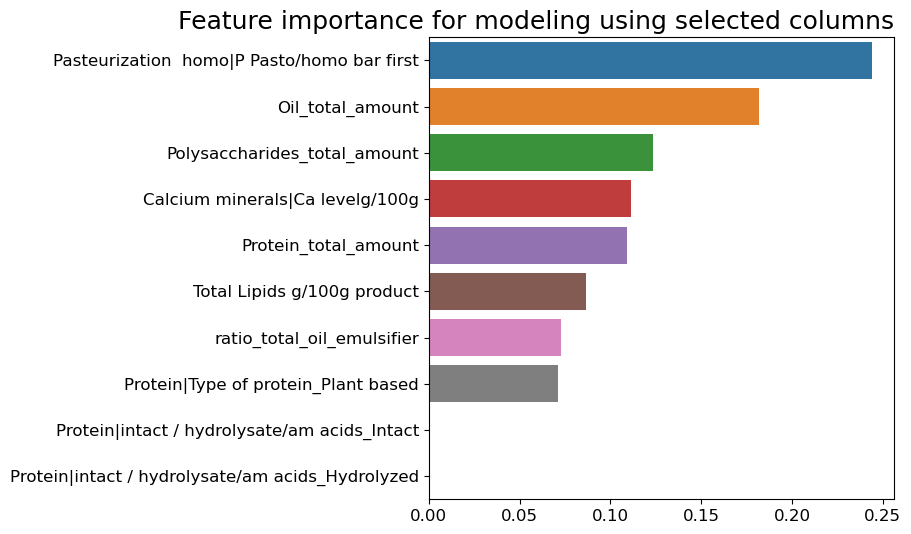

In [58]:
importance = clf_sel.feature_importances_
df_importance = pd.DataFrame(importance, index=X_clf.columns)
df_importance.sort_values(by=[0], ascending=False, inplace=True)
plt.rcParams['figure.figsize'] = (6, 6)
sns_plot = sns.barplot(data=df_importance[:10].transpose(), orient='h')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"Feature importance for modeling using selected columns", size=18, loc='right')
fig = sns_plot.get_figure()
fig.show()


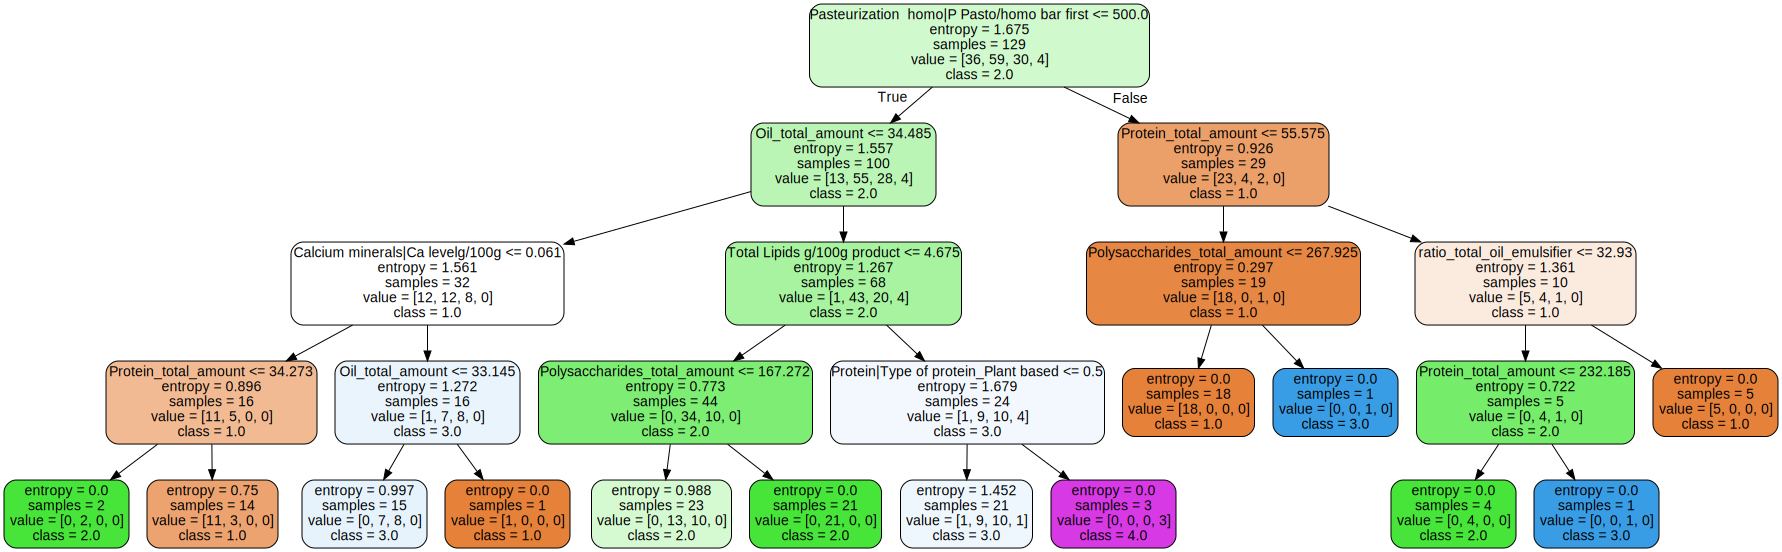

In [59]:
class_names = y_clf.unique().sort_values(ascending=True).astype(str).tolist()
dot_data = tree.export_graphviz(clf_sel, out_file=None,
                                feature_names=X_clf.columns,
                                class_names=class_names,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
# graph.render(os.path.join(path_res, f"decision_tree_clf_selected_features.png"))
graph

In [66]:
df_cluster.columns

Index(['pds_code', 'General|Category no empty cell/not merged',
       'General|Product type  no empty cell/not merged',
       'General|Subcategory no empty cell/not merged',
       'Emulsifier and oil|Phospholipids g/100mL',
       'Total Lipids g/100g product', 'FA_Sat g/100gFA',
       'FA_Mono unsat g/100gFA', 'FA_Poly unsatg/100gFA',
       'Pasteurization  homo|T°C Pasto/Homo',
       ...
       'Protein_Yoghurt powder', 'Protein_whey protein hydrolysate',
       'Protein_total_amount', 'Pasteurization  homo|P Pasto/homo bar first',
       'Pasteurization  homo|P Pasto/homo bar second',
       'Sterilization US homo|P Sterilization US bar first',
       'Sterilization US homo|P Sterilization US bar second',
       'SterilizationDS homo|P Steril DS first',
       'SterilizationDS homo|P Steril DS second',
       'ratio_total_oil_emulsifier'],
      dtype='object', length=121)

<Axes: xlabel='General|Category no empty cell/not merged', ylabel='Pasteurization  homo|P Pasto/homo bar first'>

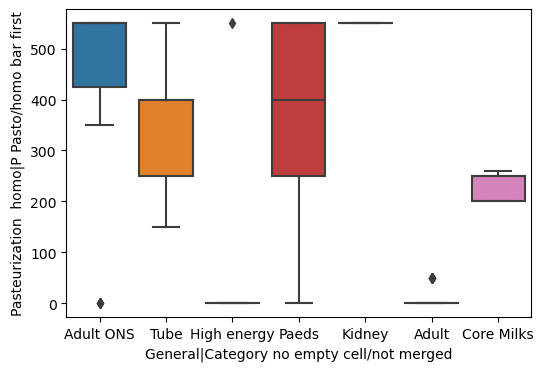

In [71]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_cluster, y="Pasteurization  homo|P Pasto/homo bar first", x="General|Category no empty cell/not merged")

<Axes: xlabel='General|Category no empty cell/not merged', ylabel='target'>

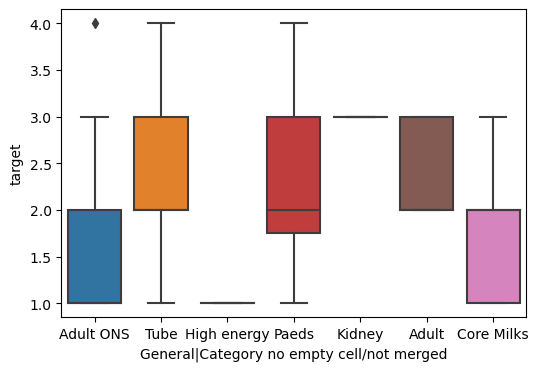

In [72]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_cluster, y="target", x="General|Category no empty cell/not merged")

In [73]:
df_cluster[df_cluster["Pasteurization  homo|P Pasto/homo bar first"] > 500]

,pds_code,General|Category no empty cell/not merged,General|Product type no empty cell/not merged,General|Subcategory no empty cell/not merged,Emulsifier and oil|Phospholipids g/100mL,Total Lipids g/100g product,FA_Sat g/100gFA,FA_Mono unsat g/100gFA,FA_Poly unsatg/100gFA,Pasteurization homo|T°C Pasto/Homo,Pasteurization|T°C Pasto,Pasteurization|Time Pasto sec,Sterilization US homo|T°C Steril US,SterilizationDS homo|T°C Steril DS,Sterilization|Direct/indirect Ste,Sterilization|F0,Sterilization|T°C Steril,Sterilization|Time Ste sec,Protein|Type of protein,Protein|intact / hydrolysate/am acids,"Protein|Prot level Nx6,25 g/100g product","Protein|casein Nx6,25g/100g product","Protein|whey protNx6,25g/100g product","Protein|SOY prot g/100g productNx6,25","Protein|PEA prot g/100g productNx6,25",Protein|Content kg/L,Stabilizers thickners|Type,Stabilizers thickners|Amount kg/1000L,Calcium minerals|Ca levelg/100g,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas,target,Emulsifier and oil|Emulsifier_Citrem LIQUID E472c,Emulsifier and oil|Emulsifier_Citrem POWDER E472c,Emulsifier and oil|Emulsifier_DIMODAN E471,Emulsifier and oil|Emulsifier_KIRNOL E471,Emulsifier and oil|Emulsifier_LAMEMUL E471,Emulsifier and oil|Emulsifier_Soy lecithin LIQUID E322,Emulsifier and oil|Emulsifier_Soy lecithin POWDER E322,Emulsifier and oil|Emulsifier_Sunflower lecithin E322,Emulsifier_total_amount,Emulsifier and oil|Oil_Algae oil DHA+EPA,Emulsifier and oil|Oil_Anhydrous milk fat,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Coconut oil,Emulsifier and oil|Oil_Corn oil,Emulsifier and oil|Oil_EPA,Emulsifier and oil|Oil_Egg lipids,Emulsifier and oil|Oil_MCT oil,Emulsifier and oil|Oil_OB 5,Emulsifier and oil|Oil_OB Canola/HO,Emulsifier and oil|Oil_Oil Blend Preterm 3,Emulsifier and oil|Oil_Oil Tuna Fish /DHA,Emulsifier and oil|Oil_Oil arachidonic acid / ARA,Emulsifier and oil|Oil_Oil blend Acropolis & Algae oil DHA+EPA,Emulsifier and oil|Oil_Oil blend Fish DHA EPA,Emulsifier and oil|Oil_Oil evening primrose,Emulsifier and oil|Oil_Oil fish EPA:18 DHA:12,Emulsifier and oil|Oil_Organic OB POF,Emulsifier and oil|Oil_Palm oil,Emulsifier and oil|Oil_Rapeseed oil,Emulsifier and oil|Oil_Soy oil,Emulsifier and oil|Oil_Sunflower oil,Emulsifier and oil|Oil_corn oil,Oil_total_amount,Polysaccharides_Fructose,Polysaccharides_Glucose,Polysaccharides_Glucose syrup,Polysaccharides_Isomaltulose,Polysaccharides_Lactose,Polysaccharides_Liquid maltodextrin,Polysaccharides_Maltodextrin,Polysaccharides_Starch,Polysaccharides_Sucrose,Polysaccharides_Sugar,Polysaccharides_total_amount,Protein_Calcium caseinates,Protein_Casein hydrolysate,Protein_Concentrated skimmed milk,Protein_Demineralized whey permeate 125% protein ORGANIC,Protein_Demineralized whey permeate 90,Protein_IP LQD DCI 12% No premix UF,Protein_IP PWD HYDR ACID WHEY,Protein_LIsoleucine,Protein_LLeucine,Protein_LValine,Protein_Lactofidus BP POF P1,Protein_Milk Casein Isolate,Protein_Milk Protein Concentrate,Protein_Milk Protein Isolate,Protein_Milk minerals concentrates,Protein_Pea protein,Protein_Pea protein isolate,Protein_Pepti permeate,Protein_Potassium caseinate,Protein_Skimmed milk Liquid,Protein_Skimmed milk Powder ORGANIC,Protein_Sodium caseinate,Protein_Soy protein isolate,Protein_WPC,Protein_WPC80 Native,Protein_WPC80 Native low Lactose,Protein_WPC83 Native,Protein_WPI Acid,Protein_WPI Native,Protein_WPI neutralized,Protein_WPI sweet,Protein_Whey protein hydrolysate,Protein_Whey rich in milk calcium,Protein_Yoghurt powder,Protein_whey protein hydrolysate,Protein_total_amount,Pasteurization homo|P Pasto/homo bar first,Pasteurization homo|P Pasto/homo bar second,Sterilization US homo|P Sterilization US bar first,Sterilization US homo|P Sterilization US bar second,SterilizationDS homo|P Steril DS first,SterilizationDS homo|P Steril DS second,ratio_total_oil_emulsifier
0,10103262,Adult ONS,CUBITAN,NA,0.000,3.225499,14

# decision tree regression

In [62]:
X_num = df_cluster.drop(["pds_code", "target"], axis=1)
X_num = X_num.select_dtypes(include='number')
X_num.fillna(0, inplace=True)
y_num = df_cluster["target"]
regr = DecisionTreeRegressor(max_depth=4, random_state=123)
regr.fit(X_num, y_num)
print(X_num.shape)
pred = regr.predict(X_num)
pred = pred.round(0)
pred
print("accuracy_score =", accuracy_score(y_num, pred))


(129, 112)
accuracy_score = 0.7906976744186046


C:\Users\sunqb\AppData\Local\Temp\ipykernel_14120\2742107504.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


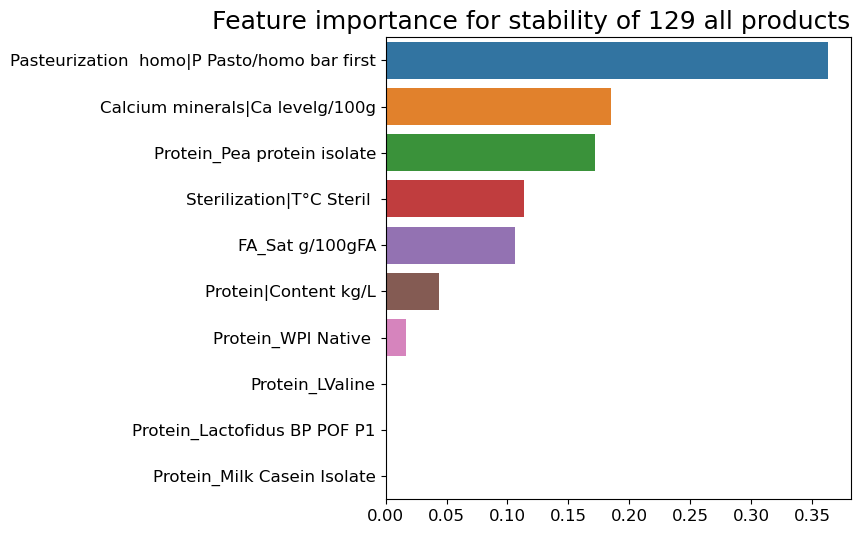

In [63]:
importance = regr.feature_importances_
df_importance = pd.DataFrame(importance, index=X_num.columns)
df_importance.sort_values(by=[0], ascending=False, inplace=True)
plt.rcParams['figure.figsize'] = (6, 6)
sns_plot = sns.barplot(data=df_importance[:10].transpose(), orient='h')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"Feature importance for stability of {len(df_cluster)} {cluster_name} products", size=18, loc='right')
fig = sns_plot.get_figure()
fig.show()


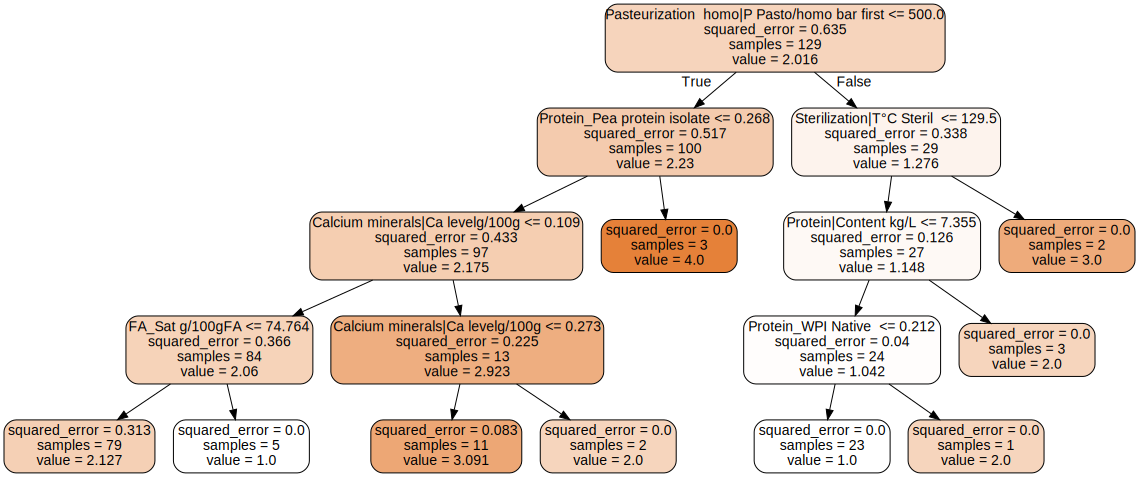

In [64]:
class_names = pd.Series(y_num.unique()).sort_values(ascending=True).astype(str).tolist()
dot_data = tree.export_graphviz(regr, out_file=None,
                                feature_names=X_num.columns,
                                class_names=class_names,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
graph.render(os.path.join(path_res, f"decision_tree_regr_{cluster_name}.png"))
graph

In [65]:
viz = dtreeviz.model(regr, X_num, y_num,
                     target_name="target",
                     feature_names=X_num.columns)
viz.view()
v = viz.view()
v.show()


C:\Users\sunqb\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


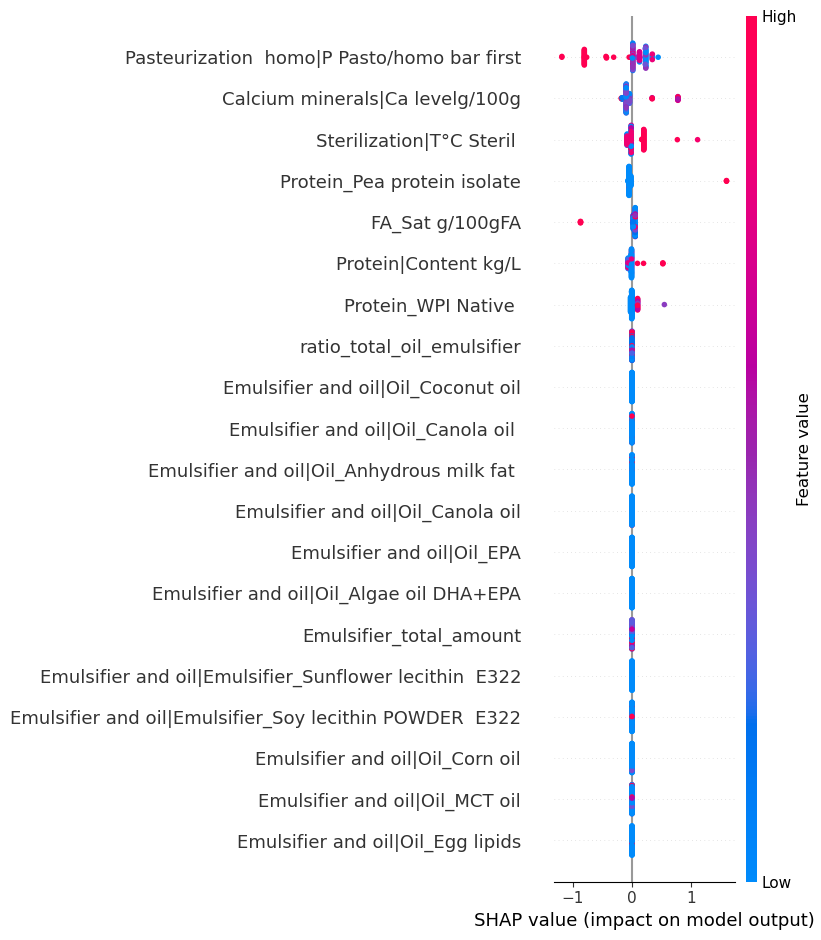

In [ ]:
# explanation by SHAP
import shap
shap.initjs()
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_num)
shap.summary_plot(shap_values, X_num, feature_names=X_num.columns, class_names=class_names)

### regression on selected features

In [ ]:
col_to_keep = ["pds_code", "target", "Total Lipids g/100g product", 
            #    "ratio_total_oil_emulsifier", 
               "Protein|Type of protein", "Protein|intact / hydrolysate/am acids"]
col_to_keep.extend(df_processed.columns[df_processed.columns.str.contains('total_amount')])
print(col_to_keep)
df_selected = df_processed[col_to_keep]

X_num_sel = df_selected.drop(["pds_code", "target"], axis=1)
X_num_sel = X_num_sel.select_dtypes(include='number')
y_num = df_selected["target"]
regr_sel = DecisionTreeRegressor(max_depth=4, random_state=123)
regr_sel.fit(X_num_sel, y_num)
pred = regr_sel.predict(X_num_sel)
pred = pred.round(0)
pred
print("accuracy_score =", accuracy_score(y_num, pred))


['pds_code', 'target', 'Total Lipids g/100g product', 'Protein|Type of protein', 'Protein|intact / hydrolysate/am acids', 'Emulsifier_total_amount', 'Oil_total_amount', 'Polysaccharides_total_amount', 'Protein_total_amount']
accuracy_score = 0.7364341085271318


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


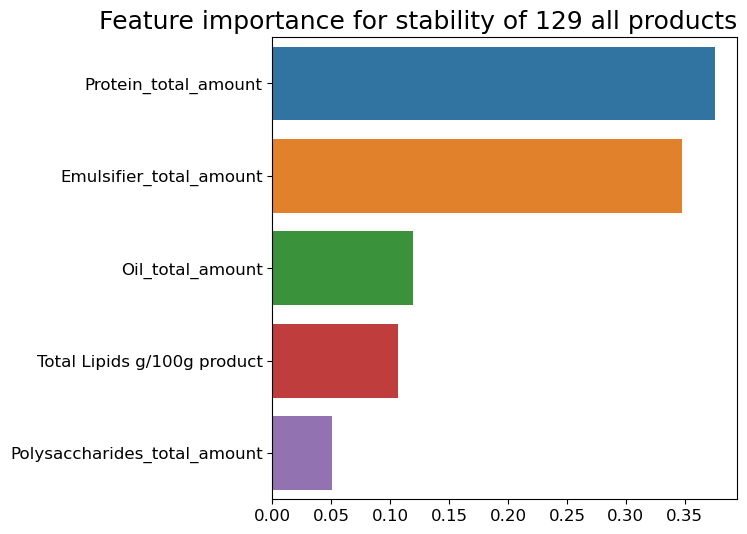

In [ ]:
importance = regr_sel.feature_importances_
df_importance = pd.DataFrame(importance, index=X_num_sel.columns)
df_importance.sort_values(by=[0], ascending=False, inplace=True)
plt.rcParams['figure.figsize'] = (6, 6)
sns_plot = sns.barplot(data=df_importance[:10].transpose(), orient='h')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f"Feature importance for stability of {len(df_cluster)} {cluster_name} products", size=18, loc='right')
fig = sns_plot.get_figure()
fig.show()

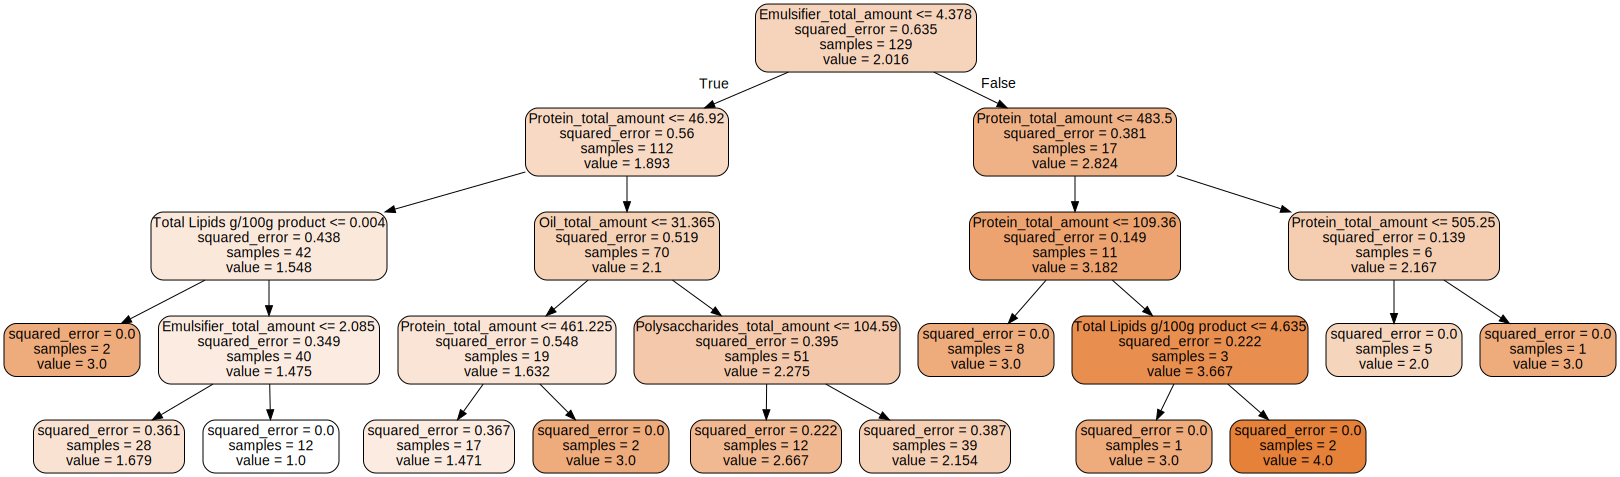

In [ ]:
class_names = pd.Series(y_num.unique()).sort_values(ascending=True).astype(str).tolist()
dot_data = tree.export_graphviz(regr_sel, out_file=None,
                                feature_names=X_num_sel.columns,
                                class_names=class_names,
                                filled=True,
                                rounded=True)
graph = graphviz.Source(dot_data)
# graph.render(os.path.join(path_res, f"decision_tree_regr_{cluster_name}.png"))
graph

In [ ]:
viz = dtreeviz.model(regr_sel, X_num_sel, y_num,
                     target_name="target",
                     feature_names=X_num_sel.columns)
viz.view()
v = viz.view()
v.show()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


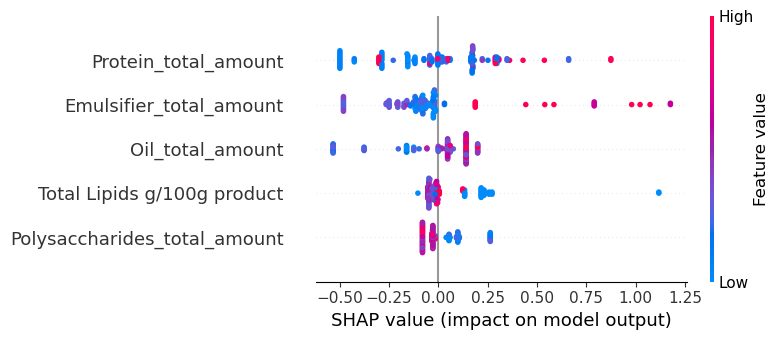

In [ ]:
# explanation by SHAP
import shap
shap.initjs()
explainer = shap.TreeExplainer(regr_sel)
shap_values = explainer.shap_values(X_num_sel)
shap.summary_plot(shap_values, X_num_sel, feature_names=X_num_sel.columns, class_names=class_names)

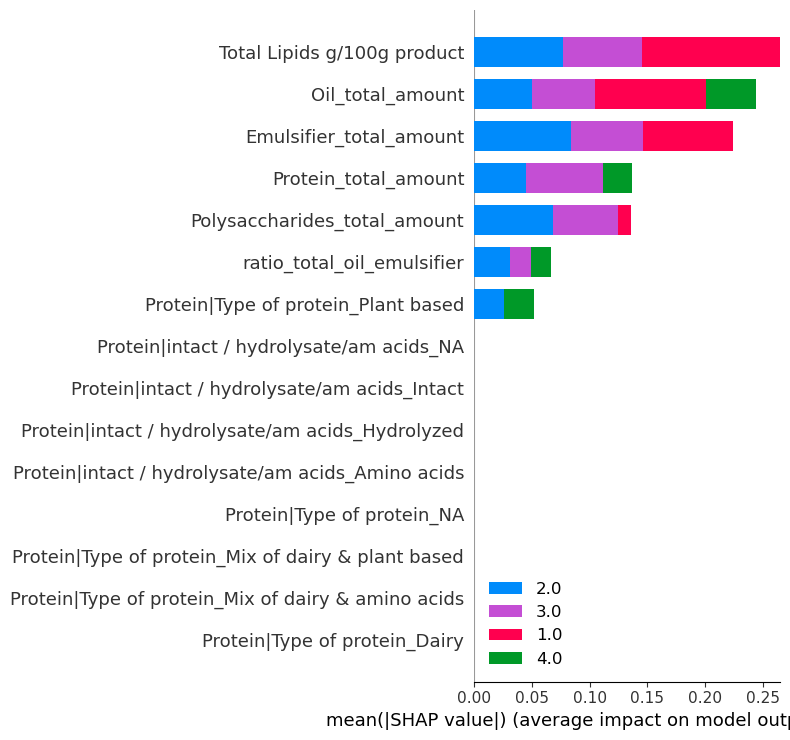

In [ ]:
# explanation by SHAP
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_sel)
shap_values = explainer.shap_values(X_clf)
shap.summary_plot(shap_values, X_clf, feature_names=X_clf.columns, class_names=class_names)

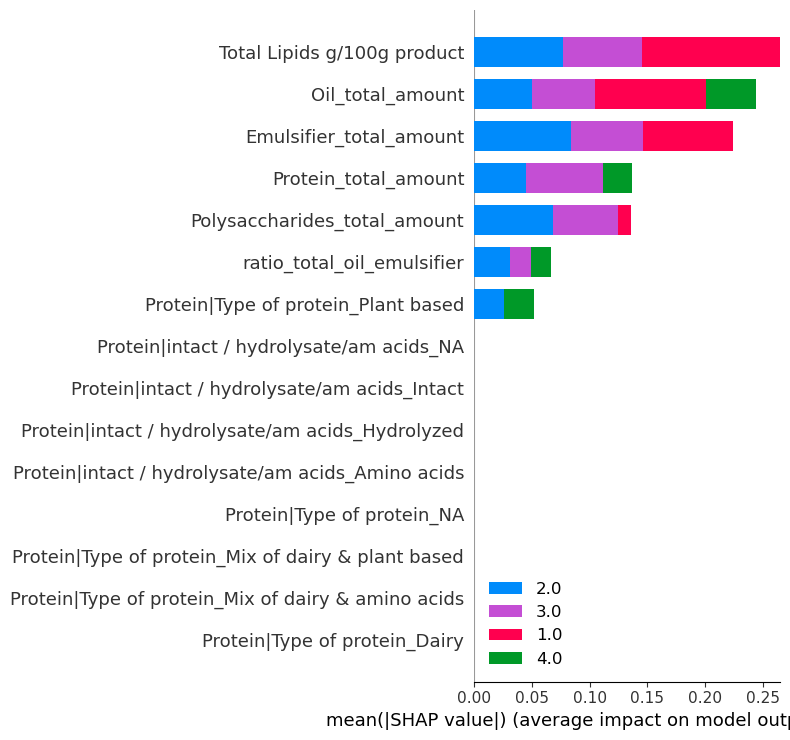

In [ ]:
# explanation by SHAP
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_sel)
shap_values = explainer.shap_values(X_clf)
shap.summary_plot(shap_values, X_clf, feature_names=X_clf.columns, class_names=class_names)

In [ ]:
correlation_matrix = X_clf.corr()

correlation_matrix

,Emulsifier and oil|Phospholipids g/100mL,Total Lipids g/100g product,FA_Sat g/100gFA,FA_Mono unsat g/100gFA,FA_Poly unsatg/100gFA,Pasteurization homo|T°C Pasto/Homo,Pasteurization|T°C Pasto,Pasteurization|Time Pasto sec,Sterilization US homo|T°C Steril US,SterilizationDS homo|T°C Steril DS,Sterilization|F0,Sterilization|T°C Steril,Sterilization|Time Ste sec,"Protein|Prot level Nx6,25 g/100g product","Protein|casein Nx6,25g/100g product","Protein|whey protNx6,25g/100g product","Protein|SOY prot g/100g productNx6,25","Protein|PEA prot g/100g productNx6,25",Protein|Content kg/L,Stabilizers thickners|Amount kg/1000L,Calcium minerals|Ca levelg/100g,Product KPI at T=0 |dry matter g/100g,Product KPI at T=0 |pH / Acidity,Product KPI at T=0 |Viscosity mPas,Emulsifier and oil|Emulsifier_Citrem LIQUID E472c,Emulsifier and oil|Emulsifier_Citrem POWDER E472c,Emulsifier and oil|Emulsifier_DIMODAN E471,Emulsifier and oil|Emulsifier_KIRNOL E471,Emulsifier and oil|Emulsifier_LAMEMUL E471,Emulsifier and oil|Emulsifier_Soy lecithin LIQUID E322,Emulsifier and oil|Emulsifier_Soy lecithin POWDER E322,Emulsifier and oil|Emulsifier_Sunflower lecithin E322,Emulsifier_total_amount,Emulsifier and oil|Oil_Algae oil DHA+EPA,Emulsifier and oil|Oil_Anhydrous milk fat,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Canola oil,Emulsifier and oil|Oil_Coconut oil,Emulsifier and oil|Oil_Corn oil,Emulsifier and oil|Oil_EPA,Emulsifier and oil|Oil_Egg lipids,Emulsifier and oil|Oil_MCT oil,Emulsifier and oil|Oil_OB 5,Emulsifier and oil|Oil_OB Canola/HO,Emulsifier and oil|Oil_Oil Blend Preterm 3,Emulsifier and oil|Oil_Oil Tuna Fish /DHA,Emulsifier and oil|Oil_Oil arachidonic acid / ARA,Emulsifier and oil|Oil_Oil blend Acropolis & Algae oil DHA+EPA,Emulsifier and oil|Oil_Oil blend Fish DHA EPA,Emulsifier and oil|Oil_Oil evening primrose,Emulsifier and oil|Oil_Oil fish EPA:18 DHA:12,Emulsifier and oil|Oil_Organic OB POF,Emulsifier and oil|Oil_Palm oil,Emulsifier and oil|Oil_Rapeseed oil,Emulsifier and oil|Oil_Soy oil,Emulsifier and oil|Oil_Sunflower oil,Emulsifier and oil|Oil_corn oil,Oil_total_amount,Polysaccharides_Fructose,Polysaccharides_Glucose,Polysaccharides_Glucose syrup,Polysaccharides_Isomaltulose,Polysaccharides_Lactose,Polysaccharides_Liquid maltodextrin,Polysaccharides_Maltodextrin,Polysaccharides_Starch,Polysaccharides_Sucrose,Polysaccharides_Sugar,Polysaccharides_total_amount,Protein_Calcium caseinates,Protein_Casein hydrolysate,Protein_Concentrated skimmed milk,Protein_Demineralized whey permeate 125% protein ORGANIC,Protein_Demineralized whey permeate 90,Protein_IP LQD DCI 12% No premix UF,Protein_IP PWD HYDR ACID WHEY,Protein_LIsoleucine,Protein_LLeucine,Protein_LValine,Protein_Lactofidus BP POF P1,Protein_Milk Casein Isolate,Protein_Milk Protein Concentrate,Protein_Milk Protein Isolate,Protein_Milk minerals concentrates,Protein_Pea protein,Protein_Pea protein isolate,Protein_Pepti permeate,Protein_Potassium caseinate,Protein_Skimmed milk Liquid,Protein_Skimmed milk Powder ORGANIC,Protein_Sodium caseinate,Protein_Soy protein isolate,Protein_WPC,Protein_WPC80 Native,Protein_WPC80 Native low Lactose,Protein_WPC83 Native,Protein_WPI Acid,Protein_WPI Native,Protein_WPI neutralized,Protein_WPI sweet,Protein_Whey protein hydrolysate,Protein_Whey rich in milk calcium,Protein_Yoghurt powder,Protein_whey protein hydrolysate,Protein_total_amount,ratio_total_oil_emulsifier,Pasteurization homo|P Pasto/homo bar first,Pasteurization homo|P Pasto/homo bar second,Sterilization US homo|P Sterilization US bar first,SterilizationDS homo|P Steril DS first,SterilizationDS homo|P Steril DS second,General|Category no empty cell/not merged_Adult,General|Category no empty cell/not merged_Adult ONS,General|Category no empty cell/not merged_Core Milks,General|Category no empty cell/not merged_High energy,General|Category no empty cell/not merged_Kidney,General|Category no empty cell/not merged_Paeds,General|Category no empty cell/not merged_Tube,General|Product type n

In [ ]:
feat_interest = "Product KPI  at T=0 |Viscosity mPas"
mask = correlation_matrix[feat_interest].abs() > 0.5
correlation_matrix[feat_interest][mask].sort_values(ascending=False)

Product KPI  at T=0 |Viscosity mPas                                  1.000000
General|Product type  no empty cell/not merged_Forticreme regular    0.987360
Protein_Milk Protein Concentrate                                     0.837837
Emulsifier and oil|Emulsifier_DIMODAN  E471                          0.641297
Sterilization|F0                                                     0.539529
Stabilizers  thickners|Type_Modified starch                          0.515895
Name: Product KPI  at T=0 |Viscosity mPas, dtype: float64

In [ ]:
correlation_matrix["Protein|Content kg/L"]["Pasteurization  homo|P Pasto/homo bar first"]

0.2281367532645035

In [ ]:
df_cluster["Total Lipids g/100g product"].fillna(0)

0      3.225499
1      1.255000
2      1.548203
3      1.369000
4      0.000000
         ...   
125    5.800000
126    7.800000
127    0.140000
128    9.570000
129    9.270000
Name: Total Lipids g/100g product, Length: 129, dtype: float64

In [ ]:
from scipy.stats import spearmanr
spearmanr(df_cluster["Oil_total_amount"].fillna(0), df_cluster["Total Lipids g/100g product"].fillna(0))

SignificanceResult(statistic=0.299707060897761, pvalue=0.0005594308357354086)

In [ ]:
spearmanr(df_cluster["Oil_total_amount"].fillna(0), df_cluster["Product KPI  at T=0 |dry matter g/100g"].fillna(0))

SignificanceResult(statistic=0.6196918000657003, pvalue=4.8903026707082986e-15)

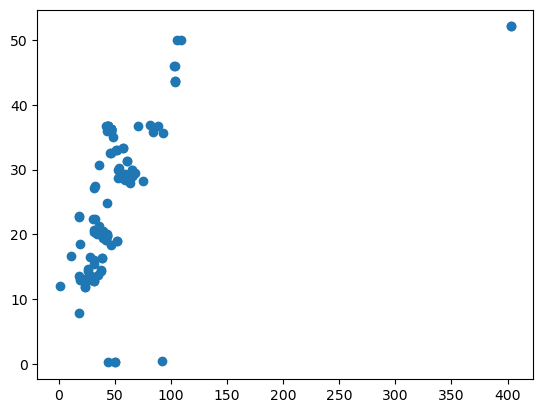

In [ ]:
plt.plot(df_cluster["Oil_total_amount"], df_cluster["Product KPI  at T=0 |dry matter g/100g"], 'o')


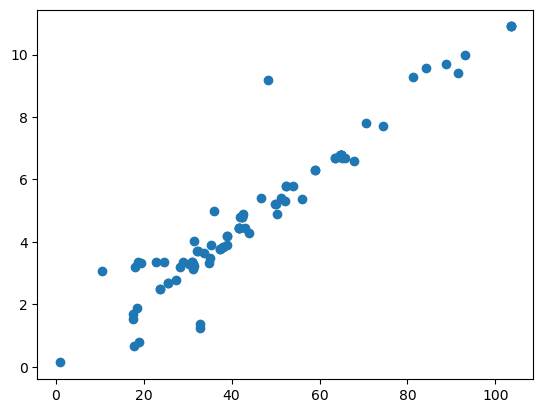

In [ ]:
plt.plot(df_cluster["Oil_total_amount"], df_cluster["Total Lipids g/100g product"], 'o')

In [ ]:
correlation_matrix["Pasteurization  homo|P Pasto/homo bar first"]["Product KPI  at T=0 |Viscosity mPas"]


-0.2738316314282516